In [1]:
# This block allows us to import from the benchmark folder,
# as if it was a package installed using pip
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from util import datasets, methods, models, plot
import numpy as np
from os import path
import matplotlib.pyplot as plt

In [3]:
# General parameters
batch_size = 2
data_root = "../data"
use_logits = True
normalize_attrs = False
aggregation_fn = "avg"
dataset_name = "CIFAR10"

In [4]:
if dataset_name == "MNIST":
    model = models.MNISTCNN(params_loc=path.join(data_root, "models/MNIST_cnn.pth"), output_logits=use_logits)
    model.eval()
    dataset = datasets.MNIST(batch_size=batch_size, data_location=path.join(data_root, "MNIST"))
else:
    model = models.CifarResnet(version="resnet20", params_loc=path.join(data_root, "models/CIFAR10_resnet20.pth"), num_classes=10, output_logits=use_logits)
    model.eval()
    dataset = datasets.Cifar(batch_size=batch_size, data_location=path.join(data_root, "CIFAR10"))


In [8]:
kwargs = {
    "normalize": normalize_attrs,
    "aggregation_fn": aggregation_fn
}

"""
attribution_methods = {
    "GuidedGradCAM": methods.GuidedGradCAM(model, model.get_last_conv_layer(), **kwargs),
    "Gradient": methods.Gradient(model, **kwargs),
    "InputXGradient": methods.InputXGradient(model, **kwargs),
    "IntegratedGradients": methods.IntegratedGradients(model, **kwargs),
    "GuidedBackprop": methods.GuidedBackprop(model, **kwargs),
    "Deconvolution": methods.Deconvolution(model, **kwargs),
    "Random": methods.Random(**kwargs),
    "LIME": methods.LIME(model, **kwargs)
}
"""

dl = dataset.get_dataloader(True)
ref_data = dl.dataset # expectedGradients will sample training data as references
attribution_methods = {
    "Gradient": methods.Gradient(model, **kwargs, abs=False),
    "SmoothGrad": methods.SmoothGrad(model,stdevs =0.1, n_samples=20, abs=False,**kwargs),
    "IntegratedGradients": methods.IntegratedGradients(model, **kwargs,n_steps=200),
    "ExpectedGradients": methods.ExpectedGradients(model, ref_data ,n_steps=200, **kwargs)
}

In [6]:
imgs, labels = next(iter(dataset.get_dataloader(train=False)))


ExpectedGradients


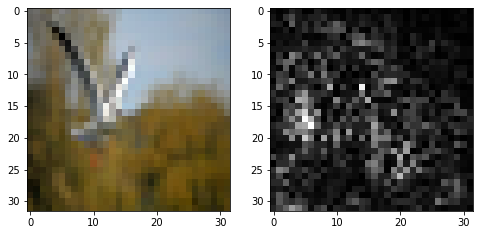

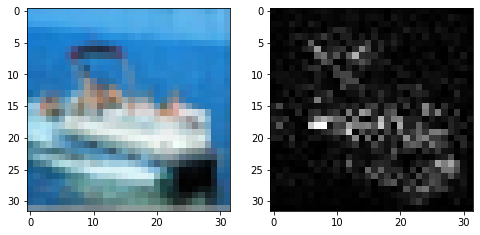

In [9]:
for m in attribution_methods:
    print(m)
    attrs = attribution_methods[m](imgs, labels)
    for i in range(batch_size):
        plot.plot_image_with_attributions(imgs[i].detach().numpy(), attrs[i].abs().detach().numpy())
        plt.show()